In [1]:
import csv
import os
import re
import random
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.utils import class_weight

import  tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Reshape, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Embedding
from tensorflow.keras.models import Model



## Cargo Data

In [4]:
WORKDIR = '/home/dipa/PycharmProjects/metadata_clasificar_preguntas/'
TRAIN_DATA = os.path.join(WORKDIR, 'dataset/train.csv')

In [5]:
corpus = []
num_questions = 0

with open(TRAIN_DATA, 'r') as f:
    reader = csv.reader(f, delimiter='|')
    next(reader)
    for row in reader:
        list_item = []
        list_item = [row[0], row[1].split('_')[1]]
        num_questions = num_questions + 1
        corpus.append(list_item)
f.close()

random.shuffle(corpus)

print(num_questions)

20104


## Limpieza y Normalizacion de preguntas

In [6]:
# limpieza del texto carateres especiales

def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    
    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)
    
    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)

    return texto


In [12]:
training_size = num_questions

questions = []
labels = []

for x in range(training_size):
    question = corpus[x][0]
    question = limpiar(question)
    question = normalizar(question)
    questions.append(question)
    labels.append(corpus[x][1])
    

print(training_size)
print(len(questions))
print(len(set(labels)))
#print(questions[:20])

20104
20104
352


## Params


In [13]:
max_length = 20       # tamano maximo de cada sentence/question
embedding_dim = 300   # dimension de la matiz de embeddings
trunc_type = 'post'   # trunco la oracion desde desde el final
padding_type = 'post'
oov_tok = "<OOV>"
test_portion = .2

## Proceso Data

In [14]:
tokenizer = Tokenizer()  

tokenizer.fit_on_texts(questions)

word_index = tokenizer.word_index


vocab_size = len(word_index)

questions = tokenizer.texts_to_sequences(questions)

#numeralizacion
padded = pad_sequences(questions, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(vocab_size)

#### chequeo ####

#index_word = dict([ (v,k) for (k,v) in word_index.items()])

#for q in questions[:5]:
#        question = []
#        for w in q:
#            question.append(index_word.get(w))
#        print(question)
   
#print(questions[:5])
#print(padded[:5])

5817


## Split train/val

In [15]:
split = int(test_portion * training_size)

# questions
training_questions = padded[split:]
val_questions = padded[:split]

# relabelling
# hay saltos en las labels, relabeleo de 0:351 para mas facil manipulcion

relabeling_dict = dict()
helper_label = [ label for label in range(len(np.unique(labels))) ]
for k,v in zip(np.unique(labels), helper_label):
    relabeling_dict[k] = v

labels = [ relabeling_dict.get(label) for label in labels ]


training_labels = labels[split:]
val_labels = labels[:split]


print(len(training_questions))
print(len(training_labels))
print(len(val_questions))
print(len(val_labels))

# paso todo a numpy array
training_padded = np.array(training_questions)
training_labels = np.array(training_labels)
val_padded = np.array(val_questions)
val_labels = np.array(val_labels)

16084
16084
4020
4020


352


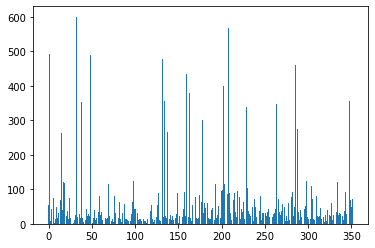

In [16]:
# compruebo que las clases se encuentran desbalanceadas

labels_num = len(set(labels))    # cantidad de labels
print(labels_num)


def CountFrequency(my_list):
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

freq_labels = CountFrequency(labels)

plt.bar(freq_labels.keys(), freq_labels.values())
plt.show()

## Embeddings

In [10]:
embedding_file = ''
embeddings_index = {}
with open('/home/dipa/PycharmProjects/metadata_clasificar_preguntas/dataset/glove-sbwc.i25.vec') as f:
     for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

## Model RNN

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix],
                              trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(labels_num, activation='softmax')   
   
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           1745400   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 352)               90464     
Total params: 2,088,536
Trainable params: 343,136
Non-trainable params: 1,745,400
_________________________________________________________________


## Model CNN

In [11]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.5

print("Creating Model...")
inputs = Input(shape=(max_length,), dtype='int32')
embedding = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embeddings_matrix],
                      input_length=max_length, trainable=False)(inputs)
reshape = Reshape((max_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(max_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(max_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(max_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
preds = Dense(labels_num, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=preds)

model.summary()

Creating Model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      1745400     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 20, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 19, 1, 512)   307712      reshape[0][0]                    
_____________________________________________________________________

## Compilo

In [12]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Entreno s/ class_weight

In [14]:
num_epochs = 20
batch_size = 64

log_file_1 = 'unbalanced.log'
csv_logger_1 = CSVLogger(log_file)



In [15]:
history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(val_padded, val_labels), verbose=2, callbacks=[csv_logger_1])

Epoch 1/20
252/252 - 58s - loss: 3.4945 - accuracy: 0.3546 - val_loss: 2.0280 - val_accuracy: 0.5540
Epoch 2/20
252/252 - 44s - loss: 1.4068 - accuracy: 0.6705 - val_loss: 1.3792 - val_accuracy: 0.6697
Epoch 3/20
252/252 - 47s - loss: 0.7942 - accuracy: 0.7991 - val_loss: 1.1634 - val_accuracy: 0.7114
Epoch 4/20
252/252 - 33s - loss: 0.5089 - accuracy: 0.8712 - val_loss: 1.0594 - val_accuracy: 0.7346
Epoch 5/20
252/252 - 34s - loss: 0.3592 - accuracy: 0.9079 - val_loss: 1.0292 - val_accuracy: 0.7418
Epoch 6/20
252/252 - 34s - loss: 0.2659 - accuracy: 0.9358 - val_loss: 1.0335 - val_accuracy: 0.7440
Epoch 7/20
252/252 - 36s - loss: 0.2118 - accuracy: 0.9450 - val_loss: 1.0053 - val_accuracy: 0.7498
Epoch 8/20
252/252 - 37s - loss: 0.1841 - accuracy: 0.9547 - val_loss: 0.9977 - val_accuracy: 0.7567
Epoch 9/20
252/252 - 42s - loss: 0.1598 - accuracy: 0.9585 - val_loss: 1.0325 - val_accuracy: 0.7473
Epoch 10/20
252/252 - 44s - loss: 0.1479 - accuracy: 0.9609 - val_loss: 1.0332 - val_accura

## Entreno c/ class_weight

In [18]:
helper_class_weight = class_weight.compute_class_weight('balanced', np.unique(labels), labels)

class_weight_dict = dict()

for k,v in zip(np.unique(labels), helper_class_weight):
    class_weight_dict[list(np.unique(labels)).index(k)] = v

In [14]:
num_epochs = 10
batch_size = 64

log_file_2 = 'balanced.log'
csv_logger_2 = CSVLogger(log_file_2')

history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs,
                     validation_data=(val_padded, val_labels), verbose=2, callbacks=[csv_logger_2], class_weight=class_weight_dict)

Epoch 1/10
252/252 - 26s - loss: 5.3816 - accuracy: 0.1169 - val_loss: 3.3509 - val_accuracy: 0.3450
Epoch 2/10
252/252 - 26s - loss: 2.1832 - accuracy: 0.4039 - val_loss: 2.3159 - val_accuracy: 0.4746
Epoch 3/10
252/252 - 28s - loss: 1.1247 - accuracy: 0.5750 - val_loss: 1.8108 - val_accuracy: 0.5719
Epoch 4/10
252/252 - 27s - loss: 0.7190 - accuracy: 0.6770 - val_loss: 1.6683 - val_accuracy: 0.5863
Epoch 5/10
252/252 - 27s - loss: 0.4939 - accuracy: 0.7415 - val_loss: 1.4554 - val_accuracy: 0.6301
Epoch 6/10
252/252 - 27s - loss: 0.3692 - accuracy: 0.7871 - val_loss: 1.3242 - val_accuracy: 0.6624
Epoch 7/10
252/252 - 27s - loss: 0.3161 - accuracy: 0.8206 - val_loss: 1.2432 - val_accuracy: 0.6813
Epoch 8/10
252/252 - 27s - loss: 0.2465 - accuracy: 0.8436 - val_loss: 1.2507 - val_accuracy: 0.6826
Epoch 9/10
252/252 - 27s - loss: 0.2104 - accuracy: 0.8646 - val_loss: 1.1843 - val_accuracy: 0.7109
Epoch 10/10
252/252 - 27s - loss: 0.1955 - accuracy: 0.8765 - val_loss: 1.1320 - val_accura

## Guardo Modelo

In [15]:
model_file = '.h5'
model.save('model_file')

## Prediccion

In [16]:

TEST_DATA = os.path.join(WORKDIR, 'dataset/test_santander.csv')

test_index = []
test_questions = []


with open(TEST_DATA, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for row in reader:
        test_index.append(row[0])
        test_question = row[1]
        test_question = limpiar(test_question)
        test_question = normalizar(test_question)
        test_questions.append(test_question)
        
test_sequences = tokenizer.texts_to_sequences(test_questions)
test_input = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


test_predictions_probas = model.predict(test_input)
test_predictions = test_predictions_probas.argmax(axis=-1)

# convierto las labels a las oriniginales
labels_transform = dict([ (v, k) for (k, v) in relabeling_dict.items() ])
predictions = dict()


prediction_file = ''

with open(prediction_file, 'w') as f:
    for k,v in zip(test_index, test_predictions):
        v = labels_transform.get(v)
        predictions[k] = v
        f.write("%s,%s\n" % (k, v))
f.close()

#print(predictions)

## Vizualizacion


In [17]:
history={'epoch' : [], 'accuracy':[], 'loss':[], 'val_accuracy': [], 'val_loss':[] }
with open(log_file_*) as training_log:
    reader=csv.DictReader(training_log)
    for row in reader:

        history['epoch'].append(row['epoch'])
        history['accuracy'].append(row['accuracy'])
        history['loss'].append(row['loss'])
        history['val_accuracy'].append(row['val_accuracy'])
        history['val_loss'].append(row['val_loss'])


acc = [ round(float(i),2) for i in history['accuracy']]
val_acc = [ round(float(i), 2) for i in history['val_accuracy']]
loss = [ round(float(i), 2) for i in  history['loss']]
val_loss = [ round(float(i), 2) for i in history['val_loss']]

epochs = range(len(acc)) # Get number of epochs

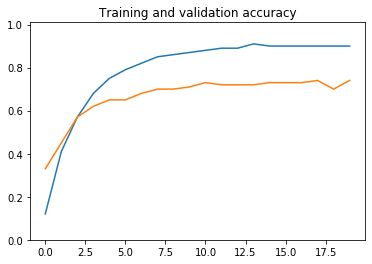

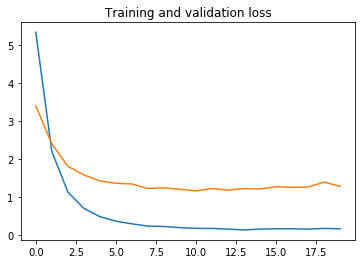

In [18]:
# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------

img_acc = 'path_acc_image_destination'

plt.plot(epochs, acc)
plt.plot(epochs, val_acc )
plt.title('Training and validation accuracy')
plt.ylim([0,1.01])
plt.savefig(img_acc)
plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------

img_loss = 'path_loss_image_destination'

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.savefig(img_loss)

plt.show()